In [23]:
#====================#
#  Import Packages   #
#====================#

import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import beta

import uproot

# BDT
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, average_precision_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_sample_weight
import joblib
import xgboost as xgb
#import shap
from matplotlib.pylab import rcParams
#import plotly.express as px
#import seaborn as sns
#from iminuit import Minuit
#import ROOT
#from tqdm import tqdm

## First to read in the flat caf files and the trees, mainly the genie truth and the rec trees.

In [24]:
#========================================================#
#  A function for creating dataframes and importing data #
#  from root files                                       #
#========================================================#
def new_df(file):
    
    
    #———————————————————————————————————————————————————————————————————#
    # First, define variables needed from the genie truth and rec trees #
    #———————————————————————————————————————————————————————————————————#

    genieEvtRec_vars = ["GenieEvtRec.StdHepPdg", 
                        "GenieEvtRec.StdHepX4", 
                        "GenieEvtRec.StdHepP4",
                        "GenieEvtRec.EvtVtx",
                        "GenieEvtRec.StdHepFm",
                        "GenieEvtRec.StdHepStatus"]

    rec_vars = ["rec.slc.truth.iscc",
                "rec.mc.nu.iscc",
                "rec.true_particles.pdg",
                "rec.true_particles.end.x",
                "rec.true_particles.end.y",
                "rec.true_particles.end.z",
                "rec.true_particles.contained"]
    
    #————————————————————————————————————
    # import the trees from the root file
    #————————————————————————————————————
    
    T_rec = uproot.open(file)['recTree']
    T_genieEvtRec = uproot.open(file)['GenieEvtRecTree']

    #—————————————————————————————————————
    # for each tree, create a data frame
    #—————————————————————————————————————
    
    
    #Reco dfs
    df_genieEvtRec = T_genieEvtRec.pandas.df(genieEvtRec_vars, flatten=False)
    df_rec = T_rec.pandas.df(rec_vars, flatten=False)

    # Convert GENIE vertex from meters → centimeters
    for i in range(3):
        df_genieEvtRec[f"GenieEvtRec.EvtVtx[{i}]"] *= 100.0

    
    #use concat to merge the individual reco dataframes
    df_ = pd.concat([df_genieEvtRec, df_rec], axis=1)

    # Add additional variables
    # ------------------------------------------------
    # CHANGE HERE TO ADD NEW VARIABLES TO DATAFRAME
    # ------------------------------------------------  

    df_ = calc_costheta_target(df_)
    df_ = GenieEvtRec_neutrino_pdg_var(df_)
    df_ = add_GenieEvtRec_iscc_var(df_)
    df_ = calc_particle_multiplicity_genie(file, df_)
    df_ = add_GenieEvtRec_proton_kinetic_energy_summaries(df_)
    df_ = add_n_showers(df_)

    return df_
    
    

## Functions for adding extra vars into the dataframe

- Create Genie-Truth isCC var 
- Creating Genie-Truth neutrino PDG var
- selection of primary muon and get their momentum separately from GenieTruth P4 var
- Lepton angle with neutrino direction estimated as the projection from the BNB target
- Lepton angle with neutrino direction estimated as the unit vector (0,0,1) in the beam direction (z)
- GENIE particle multiplicities
- New var: primary most-energetic proton's KE and sum of all primary proton's KE
-

In [25]:
def add_GenieEvtRec_iscc_var(df):
    """
    Adds a scalar CC flag (0 or 1) from rec.mc.nu.iscc,
    which is stored as a 1-element array per event.
    Returns the full dataframe with the new column added.
    """

    df_ = df.copy()

    # Flatten rec.mc.nu.iscc (looks like [1], [0], ...)
    df_["GenieEvtRec_iscc"] = df_["rec.mc.nu.iscc"].str[0]

    return df_


In [26]:
def GenieEvtRec_neutrino_pdg_var(df):
    """
    Create a new variable for the Genie-Truth neutrino PDG from the StdHepPdg array
    """
    df_ = df.copy()
    
    df_["GenieEvtRec_nuPdg"] = df_["GenieEvtRec.StdHepPdg"].str[0]
    
    return df_

In [27]:
#getting showers: primary electrons!

def get_primary_electron_first_from_row(row,
                                    pdg_col="GenieEvtRec.StdHepPdg",
                                    p4_col="GenieEvtRec.StdHepP4"):

    pdg_list = row[pdg_col]
    p4_list  = row[p4_col]

    # guard against missing data
    if pdg_list is None or p4_list is None:
        return pd.Series([np.nan, np.nan, np.nan],
                         index=["GenieEvtRec_e_px", "GenieEvtRec_e_py", "GenieEvtRec_e_pz"])

    for i, pdg in enumerate(pdg_list):
        if abs(pdg) == 11:
            px, py, pz, E = p4_list[i]
            return pd.Series([px, py, pz, E],
                             index=["GenieEvtRec_e_px", "GenieEvtRec_e_py", "GenieEvtRec_e_pz", "GenieEvtRec_e_E"])

    # no electron shower found in this event
    return pd.Series([np.nan, np.nan, np.nan, np.nan],
                     index=["GenieEvtRec_e_px", "GenieEvtRec_e_py", "GenieEvtRec_e_pz", "GenieEvtRec_e_E"])



In [28]:
#===========================================================================#
# Angle between target→vertex direction and primary electron shower (GENIE truth electron) #
#===========================================================================#

def calc_costheta_target(df):
    #-----------------------------
    # 1) Primary shower px, py, pz
    #-----------------------------
    df[["GenieEvtRec_e_px", "GenieEvtRec_e_py", "GenieEvtRec_e_pz", "GenieEvtRec_e_E"]] = df.apply(
        get_primary_electron_first_from_row, axis=1
    )

    #-----------------------------
    # 2) Vector from TARGET -> VERTEX
    #    target at (-74, 0, -110)
    #-----------------------------
    x_targ, y_targ, z_targ = -73.78, 0.0, -110.0

    # Get the vector components of the vtx position
    df.loc[:,'GenieEvtRec_nuvtxX'] = df["GenieEvtRec.EvtVtx[0]"]
    df.loc[:,'GenieEvtRec_nuvtxY'] = df["GenieEvtRec.EvtVtx[1]"]
    df.loc[:,'GenieEvtRec_nuvtxZ'] = df["GenieEvtRec.EvtVtx[2]"]


    df.eval(
        f"vec_targ_vtx_X = GenieEvtRec_nuvtxX - ({x_targ})",
        inplace=True
    )
    df.eval(
        f"vec_targ_vtx_Y = GenieEvtRec_nuvtxY - ({y_targ})",
        inplace=True
    )
    df.eval(
        f"vec_targ_vtx_Z = GenieEvtRec_nuvtxZ - ({z_targ})",
        inplace=True
    )

    #-----------------------------
    # 3) Norms of the two vectors
    #-----------------------------
    df.eval(
        "norm_vec_targ_vtx = sqrt(vec_targ_vtx_X**2 + vec_targ_vtx_Y**2 + vec_targ_vtx_Z**2)",
        inplace=True
    )
    df.eval(
        "norm_vec_e = sqrt(GenieEvtRec_e_px**2 + GenieEvtRec_e_py**2 + GenieEvtRec_e_pz**2)",
        inplace=True
    )

    #-----------------------------
    # 4) cos(theta) between them
    #   cosθ = (a·b) / (|a||b|)
    #-----------------------------
    df.eval(
        "cos_theta_bnb_target = (vec_targ_vtx_X * GenieEvtRec_e_px"
        "           + vec_targ_vtx_Y * GenieEvtRec_e_py"
        "           + vec_targ_vtx_Z * GenieEvtRec_e_pz)"
        "          / (norm_vec_targ_vtx * norm_vec_e)",
        inplace=True
    )

    # avoid 0/0
    mask_zero = (df["norm_vec_targ_vtx"] == 0) | (df["norm_vec_e"] == 0)
    df.loc[mask_zero, "cos_theta_bnb_target"] = np.nan

    return df




In [29]:
#FUNCTION NEEDS WORK: left out of BDT for now
#need to find the number of showers 'associated' with a given vertex, unsure of how to do this

def add_n_showers(df, 
                  pdg_col="GenieEvtRec.StdHepPdg", 
                  x_col="GenieEvtRec_nuvtxX",
                  y_col="GenieEvtRec_nuvtxY",
                  z_col="GenieEvtRec_nuvtxZ",
                  target_vertex=None, 
                  tol=2,
                  new_col="n_showers"):


    def count_showers_in_row(row):
        pdg_list = row[pdg_col]

        if pdg_list is None or len(pdg_list) == 0:
            return 0

        # If no target_vertex, count all electrons in the event
        if target_vertex is None:
            return sum(abs(p) == 11 for p in pdg_list)

        # Compare vertex
        vtx = [row[x_col], row[y_col], row[z_col]]
        if all(abs(vtx[i] - target_vertex[i]) < tol for i in range(3)):
            return sum(abs(p) == 11 for p in pdg_list)
        else:
            return 0

    # Apply to the DataFrame
    df[new_col] = df.apply(count_showers_in_row, axis=1)
    return df



In [30]:
def calc_particle_multiplicity_genie(filename, df_original):
    """
    Compute GENIE final-state particle multiplicities from GenieEvtRecTree
    and merge them into df_original.

    FS definition:
      - StdHepStatus == 1 (GENIE "Stable Final State")

    Energy thresholds:
      - Proton:  E > 30 MeV  (0.03 GeV)
      - Neutron: E > 5  MeV  (0.005 GeV)
      - Pion:    E > 30 MeV  (0.03 GeV)
    """

    # --- read GENIE per-particle info ---
    genie_branches = [
        "GenieEvtRec.StdHepPdg",
        "GenieEvtRec.StdHepStatus",
        "GenieEvtRec.StdHepP4",  # (px, py, pz, E)
    ]

    T_genie = uproot.open(filename)["GenieEvtRecTree"]
    DF = T_genie.pandas.df(genie_branches, flatten=True)  # includes `entry`

    # Select GENIE "Stable Final State" particles (status == 1)
    DF["GenieEvtRec_is_FS"] = (DF["GenieEvtRec.StdHepStatus"] == 1)

    # Energy in GeV (4th component)
    DF["GenieEvtRec_E"] = DF["GenieEvtRec.StdHepP4[3]"] * 1000.0


    # thresholds in MeV
    E_p_threshold   = 30.   # 30 MeV
    E_pi_threshold  = 30.   # 30 MeV
    E_n_threshold   = 5.  #  5 MeV

    # Helper: count |PDG| per entry, optionally applying extra mask
    def add_count_column(df, abs_pdg, name, extra_mask=None):
        base_mask = df["GenieEvtRec_is_FS"] & (df["GenieEvtRec.StdHepPdg"].abs() == abs_pdg)
        if extra_mask is not None:
            mask = base_mask & extra_mask
        else:
            mask = base_mask
        df_sel = df[mask]

        df.loc[:, name] = df_sel.groupby("entry")["GenieEvtRec.StdHepPdg"].transform("count")

    # Neutrons: FS + E > 5 MeV
    add_count_column(
        DF, 
        2112, 
        "countNeutron",
        extra_mask = (DF["GenieEvtRec_E"] > E_n_threshold)
    )

    # Muons: FS only
    add_count_column(DF, 13, "countMuon")

    # Kaons: FS only
    add_count_column(DF, 321, "countKaon")

    # Protons: FS + E > 30 MeV
    add_count_column(
        DF, 
        2212,
        "countProton",
        extra_mask = (DF["GenieEvtRec_E"] > E_p_threshold)
    )

    # Gammas: FS only
    add_count_column(DF, 22, "countGamma")

    # Electrons: FS only
    add_count_column(DF, 11, "countElectron")

    # Charged pions: FS + E > 30 MeV
    add_count_column(
        DF,
        211,
        "countPion",
        extra_mask = (DF["GenieEvtRec_E"] > E_pi_threshold)
    )

    # Reduce to one row per GENIE entry
    df_mult = DF[[
        "countNeutron",
        "countMuon",
        "countKaon",
        "countProton",
        "countGamma",
        "countElectron",
        "countPion",
    ]].groupby("entry").max()

    df_mult = df_mult.fillna(0).astype(int)

    # Rename columns
    df_mult = df_mult.rename(columns={
        "countNeutron":  "GenieEvtRec_Num_Neutron",
        "countMuon":     "GenieEvtRec_Num_Muon",
        "countKaon":     "GenieEvtRec_Num_Kaon",
        "countProton":   "GenieEvtRec_Num_Proton",
        "countGamma":    "GenieEvtRec_Num_Gamma",
        "countElectron": "GenieEvtRec_Num_Electron",
        "countPion":     "GenieEvtRec_Num_Pion",
    })

    # Merge with df_original on index↔entry
    df_original_idx = df_original.copy()
    df_original_idx = df_original_idx.reset_index().rename(columns={"index": "entry"})

    df_final = pd.merge(df_original_idx, df_mult, on="entry", how="left")

    # Fill NaNs
    for col in df_mult.columns:
        df_final[col] = df_final[col].fillna(0).astype(int)

    return df_final


In [31]:

def add_GenieEvtRec_proton_kinetic_energy_summaries(df):
    """
    Kinetic energy of most energetic proton and sum of proton kinetic energies (GENIE truth)       
    • Uses StdHepPdg / StdHepP4                                                                     
    • Requires:                                                                                     
        - final-state status: StdHepStatus == 1                                                    
        - |pdg| == 2212                                                                            
        - kinetic energy T > 30 MeV                                                                
    """

    proton_mass_GeV = 0.938272
    T_cut_MeV = 30.0

    Tmax_list = []
    Tsum_list = []

    for _, row in df.iterrows():
        pdg_list    = row["GenieEvtRec.StdHepPdg"]
        p4_list     = row["GenieEvtRec.StdHepP4"]
        status_list = row["GenieEvtRec.StdHepStatus"]

        Tmax = 0.0
        Tsum = 0.0

        if pdg_list is None or p4_list is None or status_list is None:
            Tmax_list.append(Tmax)
            Tsum_list.append(Tsum)
            continue

        # Loop over all GENIE particles
        for i, pdg in enumerate(pdg_list):

            # --- GENIE final-state selection ---
            if status_list[i] != 1:
                continue

            # --- Select protons ---
            if abs(pdg) != 2212:
                continue

            # --- Extract total energy E from P4 ---
            try:
                E_GeV = float(p4_list[i][3])
            except Exception:
                continue

            if E_GeV <= 0:
                continue

            # --- Compute kinetic energy ---
            T_GeV = E_GeV - proton_mass_GeV
            if T_GeV < 0:
                T_GeV = 0.0  # avoid floating errors

            T_MeV = T_GeV * 1000.0

            # --- Apply 30 MeV KE cut ---
            if T_MeV <= T_cut_MeV:
                continue

            # --- Track Tmax and Tsum ---
            Tsum += T_MeV
            if T_MeV > Tmax:
                Tmax = T_MeV

        Tmax_list.append(Tmax)
        Tsum_list.append(Tsum)

    df_out = df.copy()
    df_out["GenieEvtRec_Proton_Tmax"] = Tmax_list  # MeV
    df_out["GenieEvtRec_Proton_Tsum"] = Tsum_list  # MeV

    return df_out

## Functions for plotting

- MC category definition, including background
- Plotting function for stacked NON-area normalized distributions
- Functions to confirm the cuts and the vars applied

In [32]:
#categories adjusted to be useful for nue rather than numu

def isNueCC(df):
    mask = (df["GenieEvtRec_nuPdg"] == 12) & (df["GenieEvtRec_iscc"] == 1)
    return df[mask]

def isNuebarCC(df):
    mask = (df["GenieEvtRec_nuPdg"] == -12) & (df["GenieEvtRec_iscc"] == 1)
    return df[mask]

def isNumuCCpi0(df):
    mask_numu = (df["GenieEvtRec_nuPdg"] == 14) | (df["GenieEvtRec_nuPdg"] == -14)
    mask_cc      = (df["GenieEvtRec_iscc"] == 1)
    mask_pi = df["GenieEvtRec.StdHepPdg"].apply(
        lambda lst: any(abs(p) == 111 for p in lst)
    ).to_numpy()
    return df[mask_numu & mask_cc & mask_pi]

def isNumuCC(df):
    mask_numu = (df["GenieEvtRec_nuPdg"] == 14) | (df["GenieEvtRec_nuPdg"] == -14)
    mask_cc      = (df["GenieEvtRec_iscc"] == 1)
    mask_no_pi = df["GenieEvtRec.StdHepPdg"].apply(
        lambda lst: not any(abs(p) == 111 for p in lst)
    ).to_numpy()
    return df[mask_numu & mask_cc & mask_no_pi]

def isNCpi0(df):
    # NC with at least one neutral pion (111)
    mask_isNC = (df["GenieEvtRec_iscc"] == 0)
    mask_pi = df["GenieEvtRec.StdHepPdg"].apply(
        lambda lst: any(abs(p) == 111 for p in lst)
    ).to_numpy()
    return df[mask_isNC & mask_pi]

def isNC(df):
    # NC with NO neutral pion (111)
    mask_isNC = (df["GenieEvtRec_iscc"] == 0)
    mask_no_pi = df["GenieEvtRec.StdHepPdg"].apply(
        lambda lst: not any(abs(p) == 111 for p in lst)
    ).to_numpy()
    return df[mask_isNC & mask_no_pi]


    


In [33]:
#=============================================#
#  Functions setting vars to plot after cuts  #
#=============================================#

def plots_for_SelectionCuts(df_, label, condition='default'):
    
    # this function makes all the plots that you want to plot throughout the pre-selection cuts
    
    if (condition=='default'):
        # --- MC/DATA comparison
        # x-dir reco neutrino vertex (also plot zoomed in edges)
        mc_data_stacked_hist(df_, "GenieEvtRec.EvtVtx[0]", \
                            "plots/%s_nuvtxX" % label, "True neutrino Vertex X [cm]", \
                            -200., 200, 25)
        
        # y-dir reco neutrino vertex (also plot zoomed in edges)
        mc_data_stacked_hist(df_, "GenieEvtRec.EvtVtx[1]", \
                            "plots/%s_nuvtxY" % label, "True neutrino Vertex Y [cm]", \
                            -200., 200., 25)
        # z-dir reco neutrino vertex (also plot zoomed in edges)
        mc_data_stacked_hist(df_, "GenieEvtRec.EvtVtx[2]", \
                            "plots/%s_nuvtxZ" % label, "True neutrino Vertex Z [cm]", \
                            -25., 500., 25)


        # Flash Time (temporarily used as 1 bin histo)
        mc_data_stacked_hist(df_, "GenieEvtRec.EvtVtx[1]",\
                            "plots/%s_1_bin_histogram" % label, "1-Bin (A.U.)", \
                            -1000, 1000, 1)

        # # 1 bin histo with no category, data vs rest
        # mc_data_stacked_hist_no_cat(df_, "GenieEvtRec.EvtVtx[1]", \
        #                     "plots/%s_1" % label, "1-Bin (A.U.)", \
        #                     1000, 1000, 1)

    
        # calculated theta angle b/w beam and muon
        mc_data_stacked_hist(df_, "cos_theta_bnb_target",\
                            "plots/%s_cos_theta" % label, r"cos($\theta$) w.r.t the Projected BNB target",\
                            -1.2, 1.2, 25)
        
    
        

In [34]:
#=============================================#
#  A Function for Plotting Stacked Histograms #
#=============================================#


def mc_data_stacked_hist(df_, var, plot_png_name, xaxis,
                         xmin, xmax, nbins):

    #————————————————————————————————————————————————#
    # Restrict the range of df in the plotting range #
    #————————————————————————————————————————————————#
    
    # df_data = df_data[(df_data[var]>=xmin) & (df_data[var]<=xmax)]
    # df_ext = df_ext[(df_ext[var]>=xmin) & (df_ext[var]<=xmax)]
    # df_mc = df_mc[(df_mc[var]>=xmin) & (df_mc[var]<=xmax)]
    # df_dirt = df_dirt[(df_dirt[var]>=xmin) & (df_dirt[var]<=xmax)]
    
    #————————————————————————————————————————————#
    # Get the number of entries for each dataset #
    #————————————————————————————————————————————#
    
    n_mc = len(df_)

    #————————————————————————————#
    # Classify MC by topology
    #————————————————————————————#

    # νμ CC (no π0)
    df_numuCC = isNumuCC(df_)
    n_numuCC = len(df_numuCC)

    # νμ CC π0
    df_numuCCpi0 = isNumuCCpi0(df_)
    n_numuCCpi0 = len(df_numuCCpi0)

    # NC (no π0)
    df_nc = isNC(df_)
    n_nc = len(df_nc)

    # NC π0
    df_ncpi0 = isNCpi0(df_)
    n_ncpi0 = len(df_ncpi0)

    # νe CC
    df_nueCC = isNueCC(df_)
    n_nueCC = len(df_nueCC)

    # ν̅e CC
    df_nuebarCC = isNuebarCC(df_)
    n_nuebarCC = len(df_nuebarCC)

    print(f'\nOverlay ({n_mc} entries)')
    print(f'NumuCC        {n_numuCC:10d}')
    print(f'NumuCC π0     {n_numuCCpi0:10d}')
    print(f'NC            {n_nc:10d}')
    print(f'NC π0         {n_ncpi0:10d}')
    print(f'NueCC         {n_nueCC:10d}')
    print(f'NuebarCC      {n_nuebarCC:10d}')
    print(f'Total         {(n_numuCC + n_numuCCpi0 + n_nc + n_ncpi0 + n_nueCC + n_nuebarCC):10d}')

    #————————————————————————————#
    # Histogram inputs (order matters!)
    #————————————————————————————#

    hist_list = [
        df_numuCC[var],
        df_numuCCpi0[var],
        df_nc[var],
        df_ncpi0[var],
        df_nueCC[var],
        df_nuebarCC[var]
    ]

    #————————————————————————————#
    # get weight  (commented out for now)
    #————————————————————————————#
    # w_list = [df_cosmic[weight],
    #           df_outFV[weight],
    #           df_numuCC[weight],
    #           df_numuCCpi0[weight],
    #           df_nc[weight],
    #           df_ncpi0[weight],
    #           df_nueCC[weight],
    #           df_nuebarCC[weight],
    #           df_ext[weight],
    #           df_dirt[weight]]

    #————————————————————————————#
    # Colors
    #————————————————————————————#
    c_list = [
        'paleturquoise',  # numu CC
        'red',            # numu CC π0
        'limegreen',      # NC
        'aqua',           # NC π0
        'orange',         # nue CC
        'gold'            # nuebar CC
    ]
    # c_data = 'black'

    #————————————————————————————#
    # Labels
    #————————————————————————————#
    label_list = [
        rf'$\nu_\mu$ CC ({n_numuCC})',
        rf'$\nu_\mu$ CC $\pi^0$ ({n_numuCCpi0})',
        rf'NC ({n_nc})',
        rf'NC $\pi^0$ ({n_ncpi0})',
        rf'$\nu_e$ CC ({n_nueCC})',
        rf'$\bar{{\nu}}_e$ CC ({n_nuebarCC})'
    ]

    #————————————————————————————#
    # Stat uncertainties
    #————————————————————————————#
    hists = [
        np.histogram(h, bins=nbins, range=(xmin, xmax))[0]
        for h in hist_list
    ]

    total_mc = np.sum(hists, axis=0)
    total_stat = np.sqrt(np.sum(hists, axis=0))
    h_mc_max = np.max(total_mc)

    #————————————————————————————#
    # Create Stacked Histogram
    #————————————————————————————#
    fig, ax = plt.subplots(figsize=(8, 8))
    # # xerr for uneven histo reco nu E (commented out for now)
    # if (not isinstance(nbins, int)):
    #     xerr_reco_nuE = []
    #     for i in range(len(nbins)):
    #         print(len(nbins), i)
    #         if (i<len(nbins)-1):
    #             xerr_reco_nuE.append(0.5*(nbins[i+1]-nbins[i]))

    ax.hist(hist_list,
            bins=nbins,
            range=(xmin, xmax),
            color=c_list,
            label=label_list,
            stacked=True)

    # # err_bar, data overlay, etc. (commented out for now)
    # err_bar = [np.sqrt(x) for x in h_data]
    # mid = 0.5*(b_data[1:] + b_data[:-1])
    # if (not isinstance(nbins, int)):
    #     ax.errorbar(mid, h_data, xerr=xerr_reco_nuE, yerr=err_bar, color='black', label=label_data, fmt='o')
    # else:
    #     ax.errorbar(mid, h_data, xerr=0.5*(xmax-xmin)/nbins, yerr=err_bar, color='black', label=label_data, fmt='o')
    # upvals = np.append((np.array(total_mc)+np.array(total_stat)),(np.array(total_mc)+np.array(total_stat))[-1])
    # lowvals = np.append((np.array(total_mc)-np.array(total_stat)),(np.array(total_mc)-np.array(total_stat))[-1])
    # ax.fill_between(b_data, lowvals, upvals, step='post', color='gray', hatch='///', alpha=0.3, zorder=2)

    ax.set_xlabel(xaxis, fontsize=15)
    ax.set_ylabel('Entries', fontsize=15)
    ax.set_ylim(0, 1.5 * h_mc_max)
    ax.legend(ncol=2, fontsize=12, frameon=False)

    plt.tight_layout()
    plt.savefig(f'{plot_png_name}.png', dpi=600)
    plt.show()


# MAIN ANALYSIS CODE
- Create the dataframe(s)
- Applying cut to the original dataframe (plot alongside each cut)
- 

In [35]:
#============================#
# Relevant files and paths   #
#============================#

file_RHC_BNB = "/storage/datastore-group/PPE/sbnd/PSTF_files/prodgenie_v10_06_01_g4bnb_rhc_v2_1.flat.caf.root"

In [36]:
# Ensure xxhash and lz4 are installed for uproot
import sys
import subprocess

for package in ["xxhash", "lz4"]:
    try:
        import importlib
        importlib.import_module(package)
    except ImportError:
        print(f"{package} not found. Installing via pip...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} installed successfully.")


In [37]:
df_RHC_BNB = new_df(file_RHC_BNB)

### Cutflow

#### - No cut, truth neutrino interactions
#### - Charge Current selection
#### - Vertex Containment, fiducial volume


Overlay (505463 entries)
NumuCC            264066
NumuCC π0          53246
NC                148842
NC π0              30415
NueCC               2314
NuebarCC            1117
Total             500000


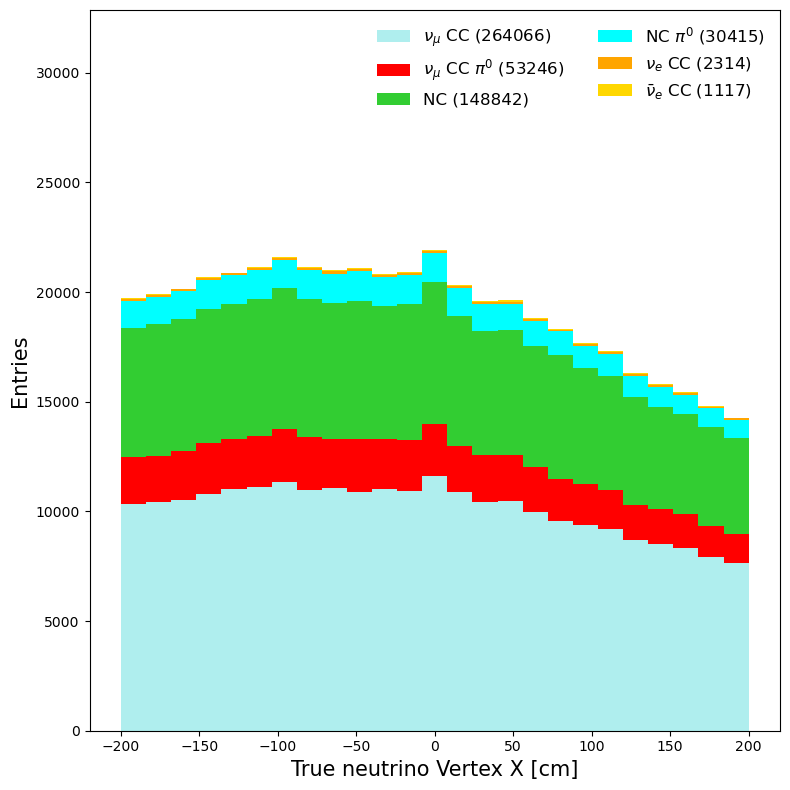


Overlay (505463 entries)
NumuCC            264066
NumuCC π0          53246
NC                148842
NC π0              30415
NueCC               2314
NuebarCC            1117
Total             500000


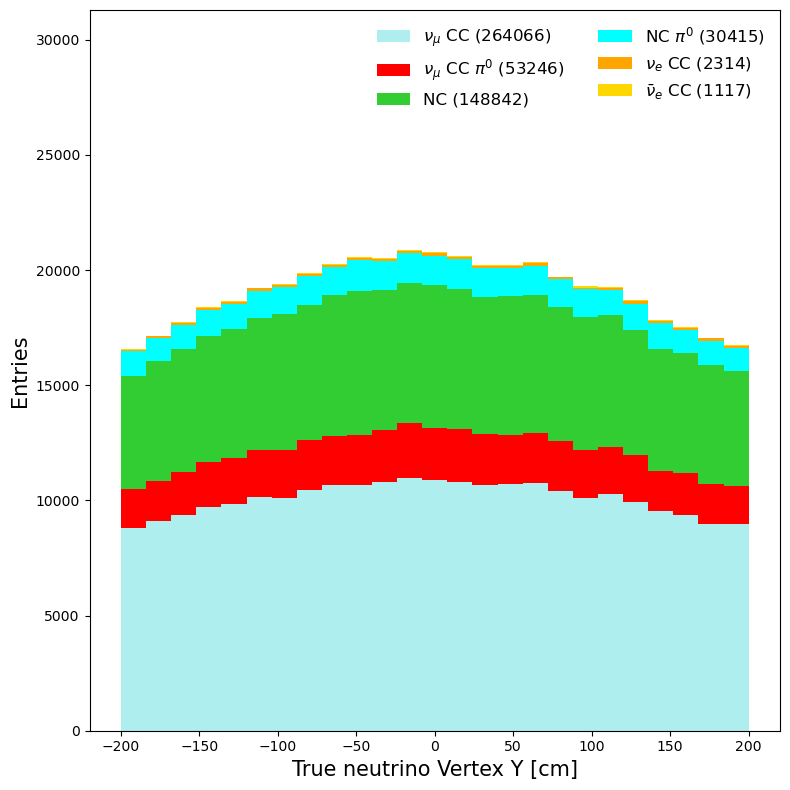


Overlay (505463 entries)
NumuCC            264066
NumuCC π0          53246
NC                148842
NC π0              30415
NueCC               2314
NuebarCC            1117
Total             500000


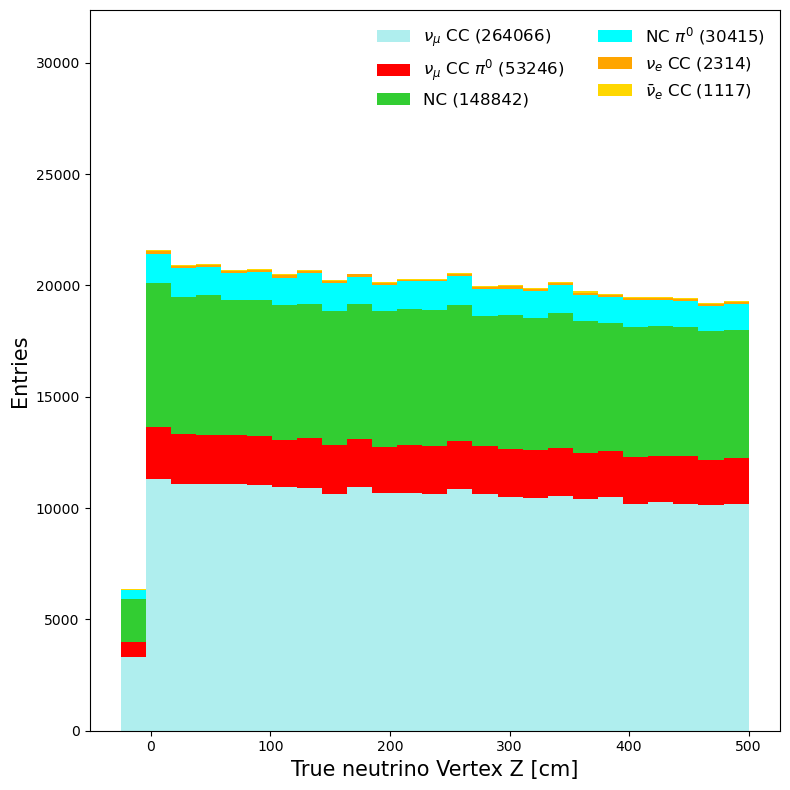


Overlay (505463 entries)
NumuCC            264066
NumuCC π0          53246
NC                148842
NC π0              30415
NueCC               2314
NuebarCC            1117
Total             500000


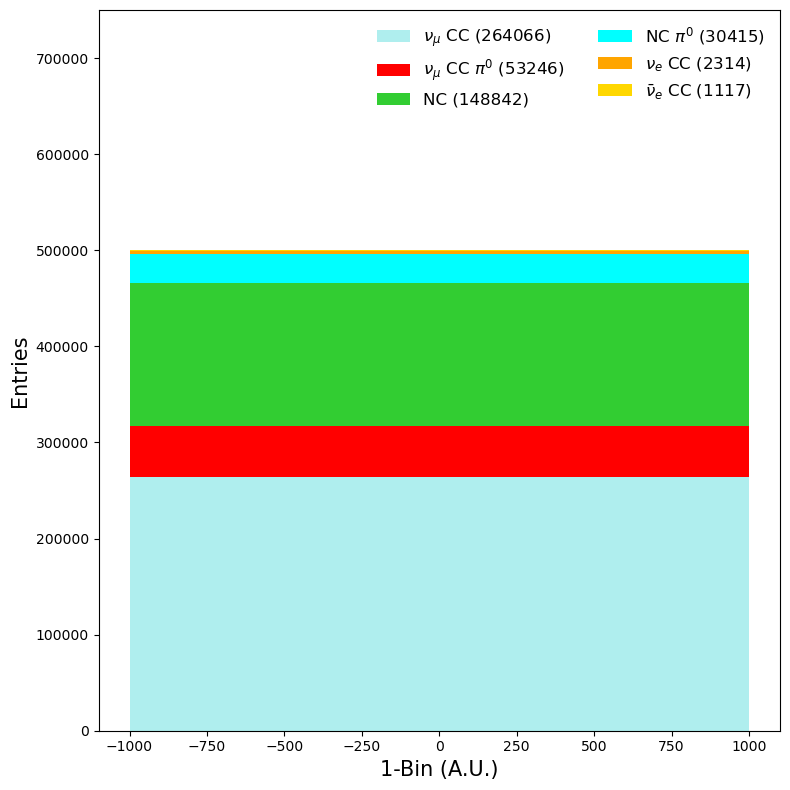


Overlay (505463 entries)
NumuCC            264066
NumuCC π0          53246
NC                148842
NC π0              30415
NueCC               2314
NuebarCC            1117
Total             500000


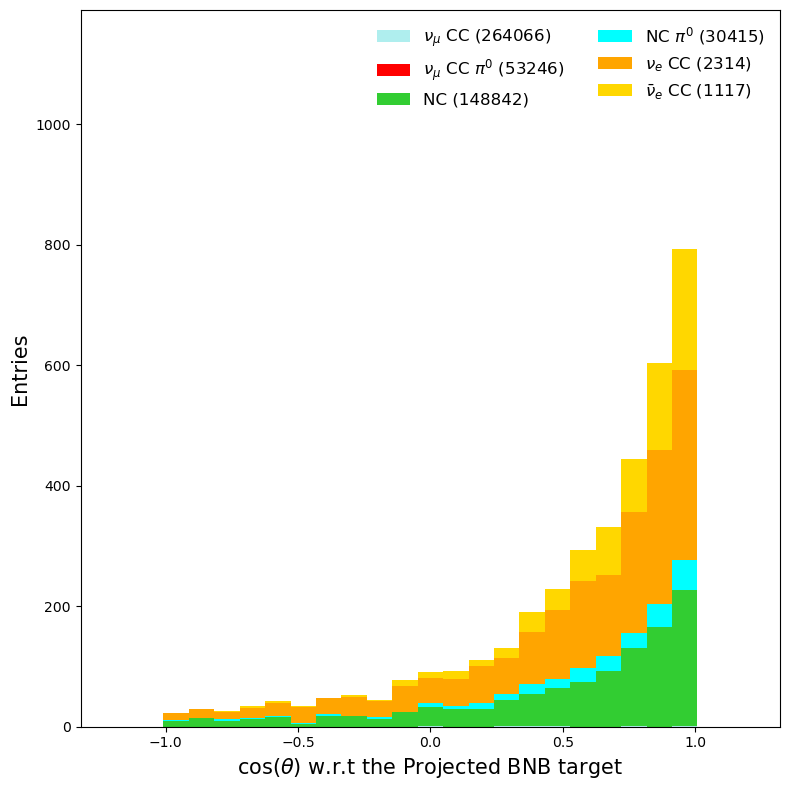

In [38]:
plots_for_SelectionCuts(df_RHC_BNB, 'RHC_BNB_all')
#df_RHC_BNB.to_hdf('dfs/df_RHC_BNB_no_selection.hdf5', key='df', mode='w')


Overlay (320743 entries)
NumuCC            264066
NumuCC π0          53246
NC                     0
NC π0                  0
NueCC               2314
NuebarCC            1117
Total             320743


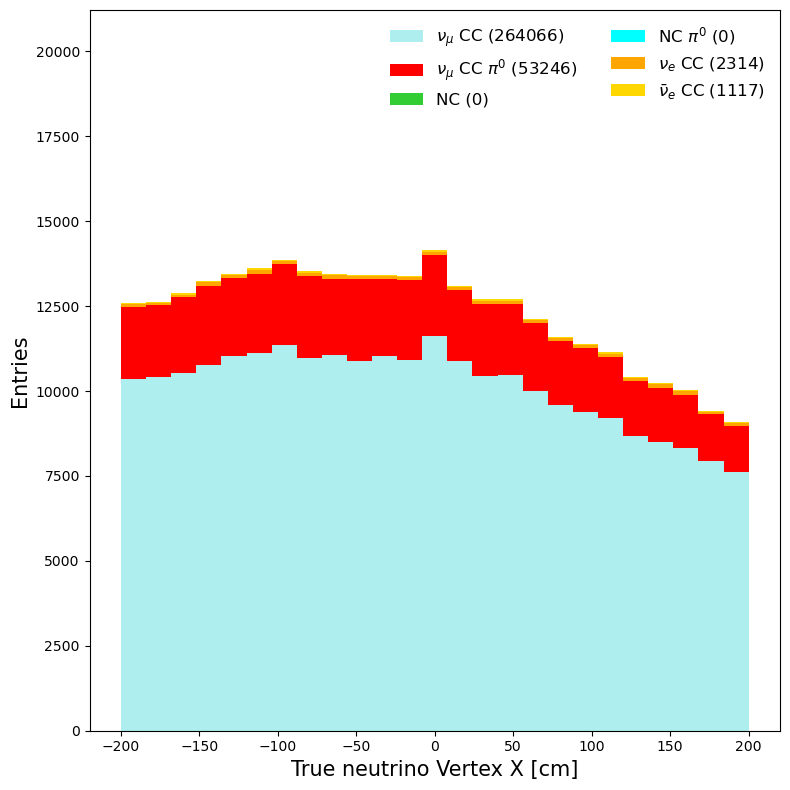


Overlay (320743 entries)
NumuCC            264066
NumuCC π0          53246
NC                     0
NC π0                  0
NueCC               2314
NuebarCC            1117
Total             320743


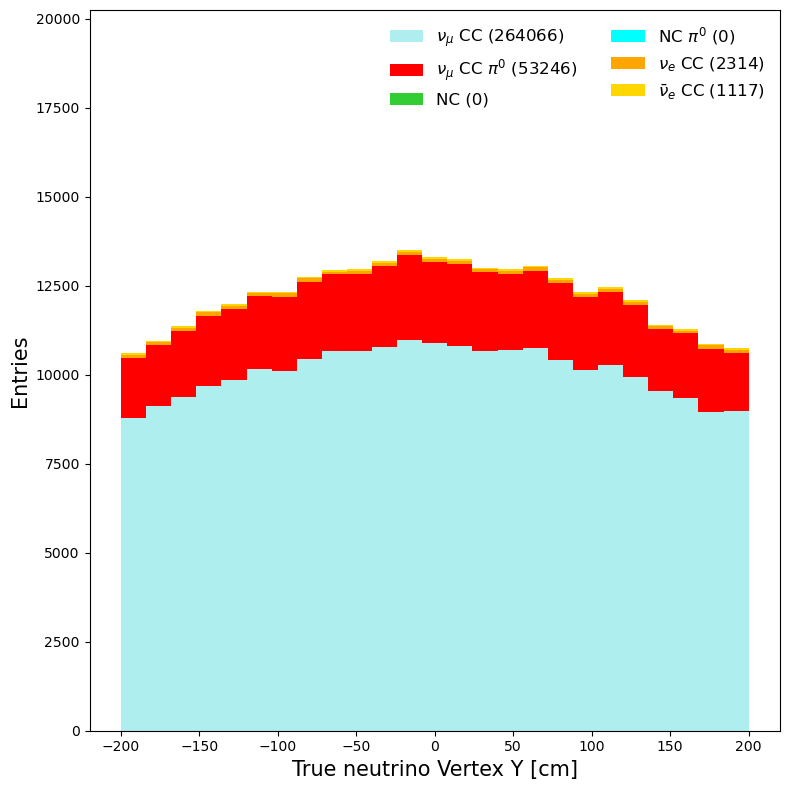


Overlay (320743 entries)
NumuCC            264066
NumuCC π0          53246
NC                     0
NC π0                  0
NueCC               2314
NuebarCC            1117
Total             320743


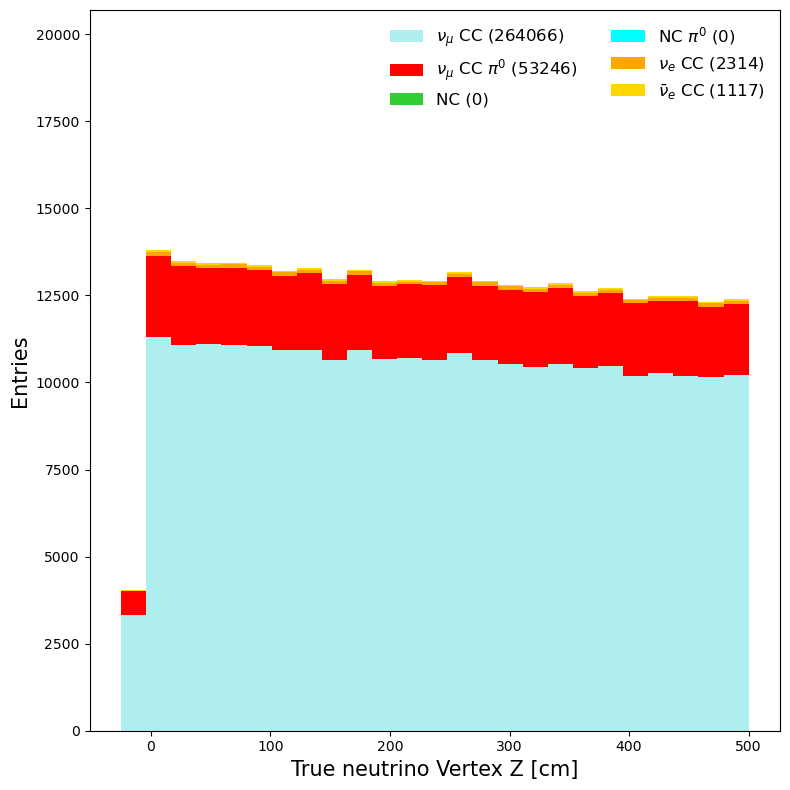


Overlay (320743 entries)
NumuCC            264066
NumuCC π0          53246
NC                     0
NC π0                  0
NueCC               2314
NuebarCC            1117
Total             320743


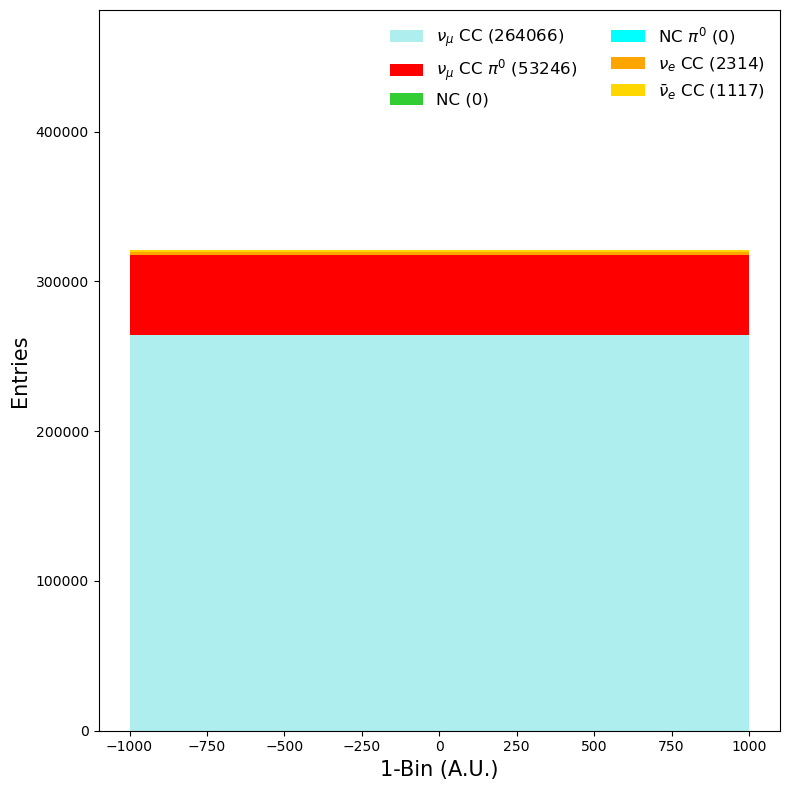


Overlay (320743 entries)
NumuCC            264066
NumuCC π0          53246
NC                     0
NC π0                  0
NueCC               2314
NuebarCC            1117
Total             320743


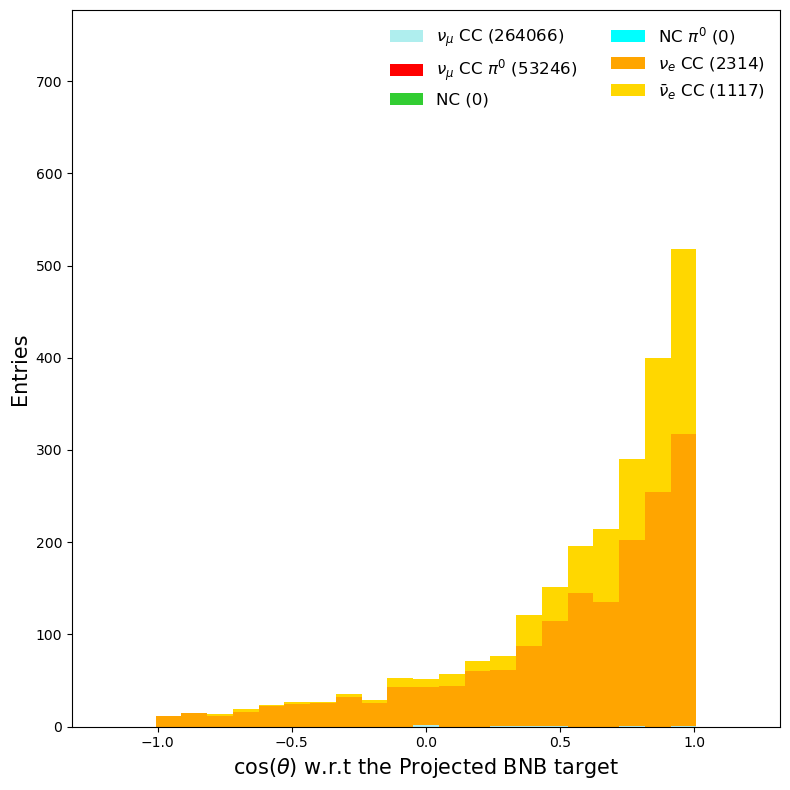

In [39]:
#==========================#
# Charge Current Selection #
#==========================#

df_RHC_BNB_CCSelection = df_RHC_BNB[(df_RHC_BNB['GenieEvtRec_iscc'] == 1)]
plots_for_SelectionCuts(df_RHC_BNB_CCSelection, 'RHC_BNB_CCSelection')
#df_RHC_BNB_CCSelection.to_hdf('dfs/df_RHC_BNB_CCSelection.hdf5', key='df', mode='w')

# BDT Stage

From the previous last selection, that's the sample that'll be used for BDT training. Due to truth study, there will be a binary BDT to separate between $\nu_\mu CC$ and $\bar{\nu}_\mu CC$. The only background will be the negligible mixed $\nu_e$ and $\bar{\nu}_e CC$ events

- Auxiliary functions used for BDT, mainly for labeling signals and creating BDT labels
- Input training variables and configure the dataset into test and train for cross-validation
- GridSearchCV for finding the most ideal BDT hyperparameters
- Plot out the relevant training metrics (error, logloss, auc)
- Plotting the confusion matrix
- Plotting the ROC curve and printing AUC
- Feature importance on how heavy the decision trees uses a certain variables
- Feature importance on SHAP beeswarm plot for each of the class
- Plotting BDT score distributions

In [40]:
#==================================#
# Auxiliary functions used for BDT #
#==================================#


def label_signal(df_):
    # this function labels the sample, =1 for signal (nueCC events), and =0 for background (otherwise)  
      
    condition_nuebar = (df_['GenieEvtRec_nuPdg']==-12)
    condition_nue = (df_['GenieEvtRec_nuPdg']==12)
    condition_cc = (df_['GenieEvtRec_iscc']==1)

    condition_not_nuebar = (df_['GenieEvtRec_nuPdg']!=-12)
    condition_not_nue = (df_['GenieEvtRec_nuPdg']!=12)
    condition_not_cc = (df_['GenieEvtRec_iscc']!=1)

    
    query_nuebarcc = condition_nuebar & condition_cc
    query_nuecc = condition_nue & condition_cc
    query_others = (condition_not_nuebar | condition_not_nue) & condition_not_cc

    df_nuecc_init = df_[(query_nuecc)]
    df_nuebarcc_init = df_[(query_nuebarcc)]
    df_others_init = df_.drop(df_nuecc_init.index, errors='ignore').drop(df_nuebarcc_init.index, errors='ignore')
    totalEvents = len(df_nuecc_init) + len(df_nuebarcc_init) + len(df_others_init)
    
    df_["bdt_nuebarcc_label"] = df_.apply(lambda row:1 if query_nuebarcc[row.name] else 0, axis=1)
    df_["bdt_nuecc_label"] = df_.apply(lambda row:1 if query_nuecc[row.name] else 0, axis=1)
    df_["bdt_others_label"] = df_.apply(lambda row:1 if query_others[row.name] else 0, axis=1)

    #Calculate the percentage of 1's
    percentage_signal_nue = (len(df_nuecc_init) / totalEvents) * 100
    print(f"Labelled dataset. Portion of signal nueCC events in this sample: {percentage_signal_nue:.2f}%")
    
    percentage_signal_nuebar = (len(df_nuebarcc_init) / totalEvents) * 100
    print(f"Labelled dataset. Portion of signal nuebarCC events in this sample: {percentage_signal_nuebar:.2f}%")

    percentage_others = (len(df_others_init) / totalEvents) * 100
    print(f"Labelled dataset. Portion of background events in this sample: {percentage_others:.2f}%")
    
def remove_background_events(df_):
    # remove any event that is not nueCC/nuebarCC
    query = "(GenieEvtRec_nuPdg==12 | GenieEvtRec_nuPdg==-12) & GenieEvtRec_iscc==1"
    num_events_before = len(df_)
    df_.query(query, inplace=True) # keep only events where query=True
    contaminant_contribution = (num_events_before - len(df_))/num_events_before
    print(f"Removed {num_events_before - len(df_)} contaminants from the selection sample. This"
          f" constitutes {contaminant_contribution:.2%} of the sample.")

In [41]:
# Rename dataframe, allowing df_bdt to be other things in the future
df_bdt = df_RHC_BNB_CCSelection

# Label the sample provided, include "bdt_nuebarcc_label" and "bdt_nuecc_label"
label_signal(df_bdt)

# Remove remaining background (everything different than nueCC/nuebarCC)
remove_background_events(df_bdt)



# ============================

chosen_var = 'bdt_nuebarcc_label' # nueccbar=signal, nuecc=background

# ============================

# List of variables used for training: currently only using cos theta, proton multiplicity, and neutron multiplicity 


training_variables = ["cos_theta_bnb_target",
                      "GenieEvtRec_Num_Proton",
                      "GenieEvtRec_Num_Neutron"]
                      #"GenieEvtRec_e_E"] #this is shower energy
                      
                       #add neutrino KE and "n_showers"


# Split the dataset into training and validation sets - using random_state as handle on the randomness of data
features = df_bdt[training_variables]
targets = df_bdt[chosen_var]

# Compute sample weights to balance the class distribution
sample_weights = compute_sample_weight(class_weight="balanced", y=targets)
features_train, features_test, targets_train, targets_test, sample_weights_train, sample_weights_test = train_test_split(features, targets, sample_weights, test_size=0.2, random_state=0)

# Create df_test using the same rows selected for features_test
df_test = df_bdt.loc[features_test.index]


features_test_sig = features_test[targets_test==1]
features_test_bkg = features_test[targets_test==0]

/home/s1702920/miniconda3/envs/python3LEE_v3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/s1702920/miniconda3/envs/python3LEE_v3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Labelled dataset. Portion of signal nueCC events in this sample: 0.72%
Labelled dataset. Portion of signal nuebarCC events in this sample: 0.35%
Labelled dataset. Portion of background events in this sample: 98.93%
Removed 317312 contaminants from the selection sample. This constitutes 98.93% of the sample.


/home/s1702920/miniconda3/envs/python3LEE_v3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/s1702920/miniconda3/envs/python3LEE_v3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Use GridSearchCV to check for the best hyper-parameters

In [42]:
lock4 = False
if lock4==True:
    xgb_dic={
        'n_estimators':[50,75,100,200,300,500],
        'max_depth': [3,4,5,6,7,10],
        'eta': [0.01,0.05,0.1,0.5]
        }

    # Deine BDT object
    xgb_classifier = xgb.XGBClassifier()

    grid = GridSearchCV(xgb_classifier, xgb_dic, n_jobs=5)
    grid.fit(features_train, targets_train)

    print(f"The best score is \t{grid.best_score_}")
    print(f"The best parameters are \t{grid.best_params_}")

    results = pd.DataFrame.from_dict(grid.cv_results_)

### Training the model

In [43]:
# Create an XGBoost classifier (we should play with these parameters)
clf = xgb.XGBClassifier(n_estimators=100, # 
                        eta=0.1, # 
                        max_depth=6, # 
                        scale_pos_weight=1, 
                        eval_metric=["error","auc", "logloss"],
                        objective='binary:logistic',
                        use_label_encoder=False # removes warning
                       )

# Train the classifier on our newly constructed dataset
eval_set = [(features_train, targets_train), (features_test, targets_test)]
clf.fit(features_train, targets_train, sample_weight=sample_weights_train, eval_set=eval_set)

[0]	validation_0-error:0.32653	validation_0-auc:0.78585	validation_0-logloss:0.66833	validation_1-error:0.32169	validation_1-auc:0.76238	validation_1-logloss:0.66767
[1]	validation_0-error:0.32653	validation_0-auc:0.78714	validation_0-logloss:0.64786	validation_1-error:0.32169	validation_1-auc:0.76290	validation_1-logloss:0.64714
[2]	validation_0-error:0.32653	validation_0-auc:0.78993	validation_0-logloss:0.63074	validation_1-error:0.32169	validation_1-auc:0.76523	validation_1-logloss:0.62980
[3]	validation_0-error:0.32507	validation_0-auc:0.79551	validation_0-logloss:0.61592	validation_1-error:0.31878	validation_1-auc:0.76724	validation_1-logloss:0.61561
[4]	validation_0-error:0.33528	validation_0-auc:0.79768	validation_0-logloss:0.60373	validation_1-error:0.33188	validation_1-auc:0.76923	validation_1-logloss:0.60365
[5]	validation_0-error:0.34257	validation_0-auc:0.80099	validation_0-logloss:0.59282	validation_1-error:0.34061	validation_1-auc:0.77384	validation_1-logloss:0.59373
[6]	

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=['error', 'auc', 'logloss'], gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.100000001,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

### Printing out relevant evaluation metric

In [44]:
# Get the relevant information for printing

results = clf.evals_result()
epochs = len(results['validation_0']['error'])

#=============================================================#
# CHANGE THE LINE BELOW IF HYPERPARAMETER (EPOCHS) IS CHANGED #

x_axis = np.linspace(0, epochs, 100, endpoint=True)
#=============================================================#

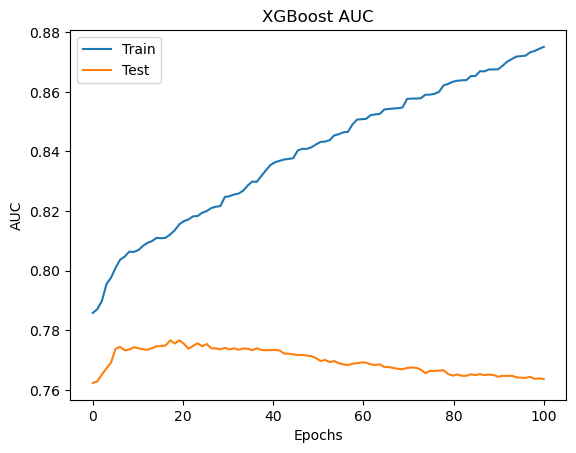

In [45]:
plt.plot(x_axis, results['validation_0']['auc'], label='Train')
plt.plot(x_axis, results['validation_1']['auc'], label='Test')
plt.legend()
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.title('XGBoost AUC')
plt.show()

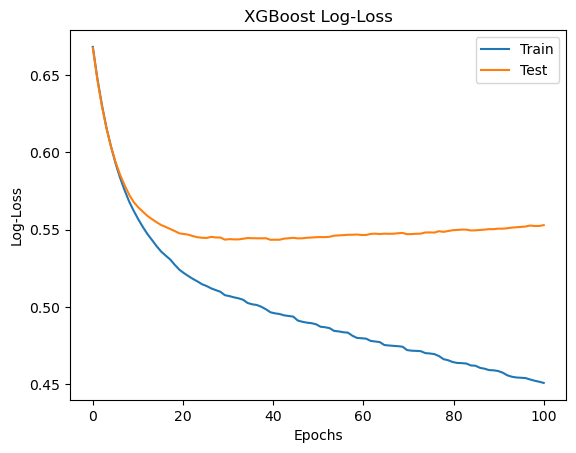

In [46]:
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
plt.legend()
plt.ylabel('Log-Loss')
plt.xlabel('Epochs')
plt.title('XGBoost Log-Loss')
plt.show()

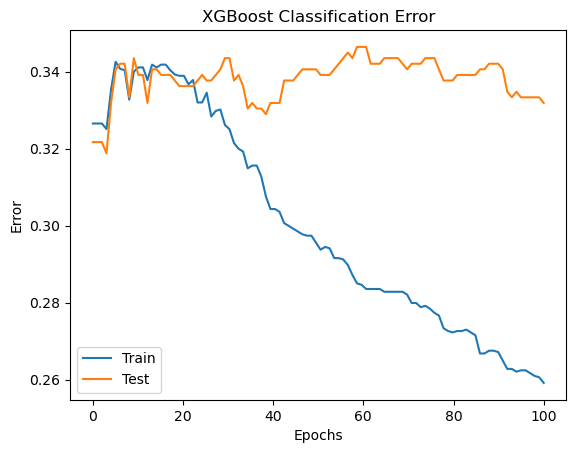

In [47]:
plt.plot(x_axis, results['validation_0']['error'], label='Train')
plt.plot(x_axis, results['validation_1']['error'], label='Test')
plt.legend()
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.title('XGBoost Classification Error')
plt.show()

### Plot the Confusion Matrix

In [48]:
# Predict class labels
y_pred = clf.predict(features_test)

# Predict class probabilities
y_proba = clf.predict_proba(features_test)

# BDT score for signal and bkg
bdt_score_nuebarcc = y_proba[:, 1]  # probability for signal
bdt_score_nuecc = y_proba[:, 0]  # probability for bkg

# Optional: print a quick check of predicted classes
unique, counts = np.unique(y_pred, return_counts=True)
print("Predicted class distribution:", dict(zip(unique, counts)))

Predicted class distribution: {0: 366, 1: 321}


In [49]:
%pip install seaborn

import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


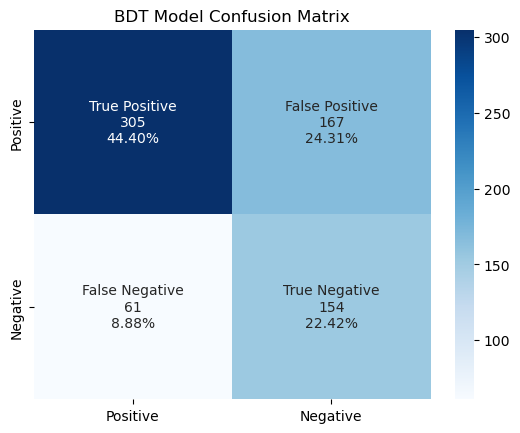

In [50]:
mc_y_pred = clf.predict(features_test)

group_names = ['True Positive', 'False Positive', 'False Negative', 'True Negative']
cm_mc = confusion_matrix(targets_test, mc_y_pred)
test_counts = ["{0:0.0f}".format(value) for value in cm_mc.flatten()]
test_percentage = ["{0:.2%}".format(value) for value in cm_mc.flatten()/np.sum(cm_mc)]
test_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,test_counts,test_percentage)]
test_labels = np.asarray(test_labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cm_mc, annot=test_labels, fmt='', cmap='Blues', ax=ax);

# labels, title and ticks

ax.set_title('BDT Model Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Positive', 'Negative']); 
ax.yaxis.set_ticklabels(['Positive', 'Negative']);

### EXTRACTING and BUILDING the ROC curve

In [51]:
from sklearn import metrics
def buildROC(target_test, test_preds, target_train, train_preds):
    fpr_test, tpr_test, _ = metrics.roc_curve(target_test, test_preds)
    fpr_train, tpr_train, _ = metrics.roc_curve(target_train, train_preds)
    roc_auc_test = metrics.auc(fpr_test, tpr_test)
    roc_auc_train = metrics.auc(fpr_train, tpr_train)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_test, tpr_test, label = 'Test - AUC = %0.2f' % roc_auc_test, color='g')
    plt.plot(fpr_train, tpr_train, label = 'Train - AUC = %0.2f' % roc_auc_train, color='b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [52]:
y_pred_proba_train = clf.predict_proba(features_train)
y_pred_proba_test = clf.predict_proba(features_test)

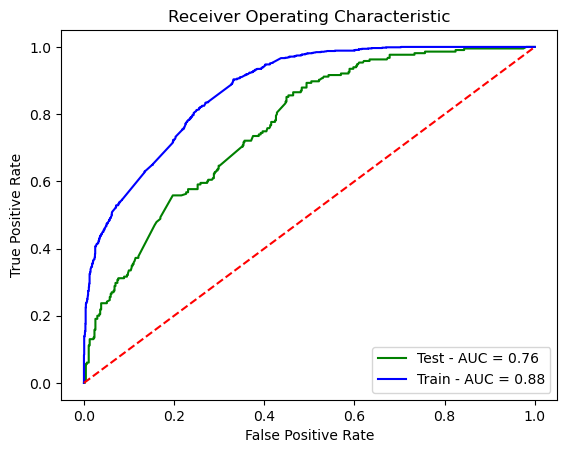

In [53]:
buildROC(targets_test, y_pred_proba_test[:, 1], targets_train, y_pred_proba_train[:, 1])

### Plotting the decision tree usage feature importance

In [54]:
def plot_important_features(features, feature_importances_, number):
    
    plt.close()
    plt.figure(figsize=(8,5))
    
    zipped = zip(features, feature_importances_)
    zipped_sort = sorted(zipped, key = lambda x:x[1], reverse=True)
    zipped_sort_reduced = zipped_sort[:number]
    
    res = [[ i for i, j in zipped_sort_reduced], 
           [ j for i, j in zipped_sort_reduced]]
    red_features = res[0]
    red_importances = res[1]
    
    plt.barh(range(len(red_importances)), red_importances, align='center')
    plt.yticks(np.arange(len(red_features)), red_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Top %i features"%(number))
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)
    plt.tight_layout()
    plt.show()
    
    return red_features

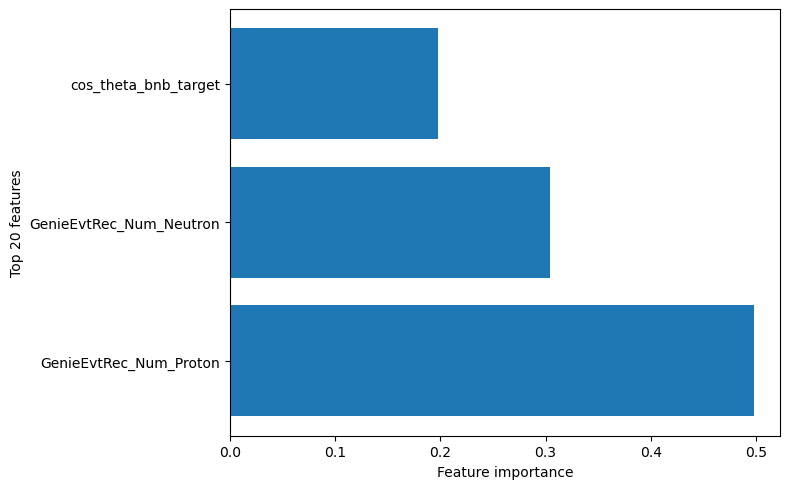

In [55]:
list_features = plot_important_features(training_variables, clf.feature_importances_, 20)

### Feature Importance looking at SHAP Beeswarm plots

In [56]:
%pip install shap
import shap

Note: you may need to restart the kernel to use updated packages.


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [57]:
# Explain predictions using SHAP
explainer = shap.Explainer(clf)
shap_values_sig = explainer(features_test_sig)
shap_values_bkg = explainer(features_test_bkg)

print(shap_values_sig.values.shape)  # should be (n_sig_samples, n_features)
print(shap_values_bkg.values.shape)  # should be (n_bkg_samples, n_features)

(215, 3)
(472, 3)


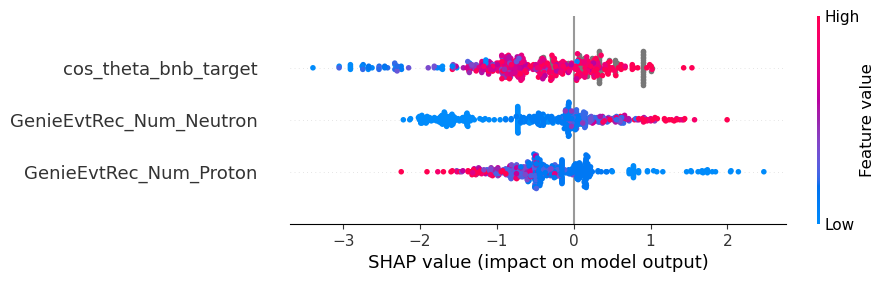

In [58]:
# Each prediction has shape [n_samples, n_classes, n_features]
# For summary plot, use per-class SHAP values
# To visualize bkg class:
shap.plots.beeswarm(shap_values_bkg, max_display=20)

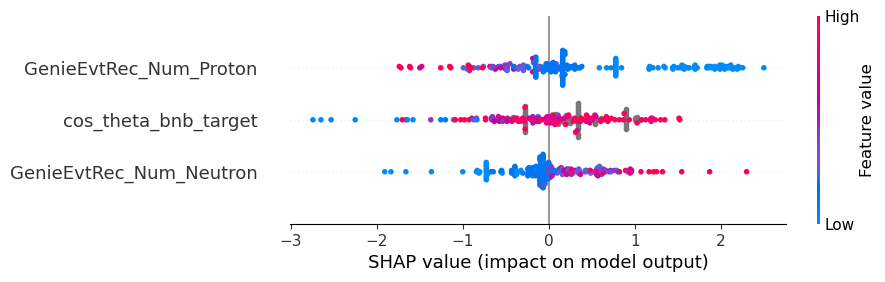

In [59]:
shap.plots.beeswarm(shap_values_sig[...], max_display=20)

### Plotting BDT scores

In [60]:
nue_mask    = df_test["bdt_nuecc_label"] == 1
nuebar_mask = df_test["bdt_nuebarcc_label"] == 1

bdt_score = clf.predict_proba(features_test)[:, 1]  # score = P(numubarCC)

bdt_score_nuebarcc = bdt_score[nuebar_mask]
bdt_score_nuecc    = bdt_score[nue_mask]

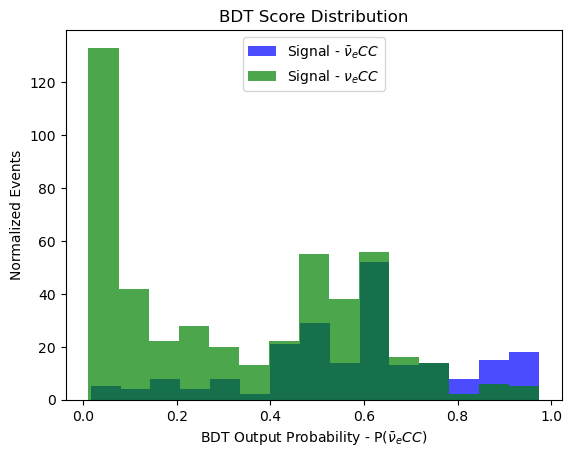

In [61]:
plt.hist(bdt_score_nuebarcc, alpha=0.7, bins=15, label=r'Signal - $\bar{\nu}_{e}CC$', color='blue', stacked=False)#, density=True)
plt.hist(bdt_score_nuecc, alpha=0.7, bins=15, label=r'Signal - $\nu_{e}CC$', color='green', stacked=False)#, density=True)
plt.xlabel(r'BDT Output Probability - P($\bar{\nu}_{e}CC$)')
plt.ylabel('Normalized Events')
plt.title('BDT Score Distribution')
plt.legend(loc='upper center')
plt.show()

### Plot the Correlation Matrices

### Plot the variables based on the truth information on the two categories

In [62]:
# First set a mask for plotting multiplicity
df_nuecc = df_bdt.query('bdt_nuecc_label==1')
df_nuebar = df_bdt.query('bdt_nuebarcc_label==1')

In [63]:
df_bdt.head(-1)

,entry,GenieEvtRec.StdHepPdg,GenieEvtRec.StdHepX4,GenieEvtRec.StdHepP4,GenieEvtRec.EvtVtx[0],GenieEvtRec.EvtVtx[1],GenieEvtRec.EvtVtx[2],GenieEvtRec.EvtVtx[3],GenieEvtRec.StdHepFm,GenieEvtRec.StdHepStatus,...,GenieEvtRec_Num_Proton,GenieEvtRec_Num_Gamma,GenieEvtRec_Num_Electron,GenieEvtRec_Num_Pion,GenieEvtRec_Proton_Tmax,GenieEvtRec_Proton_Tsum,n_showers,bdt_nuebarcc_label,bdt_nuecc_label,bdt_others_label
158,158,"[-12, 1000180400, 2212, 1000170390, 22, -11, 2...","[[1.7363951972562868, -2.383732671525981, -5.3...","[[0.024141856835900238, 0.008767379453937548, ...",131.778669,129.233555,158.655426,3.865767e-08,"[-1, -1, 1, 1, 1, 0, 2, 6, 6, 3]","[0, 0, 11, 2, 1, 1, 14, 1, 1, 15]",...,1,1,1,0,0.000000,0.000000,1,1,0,0
313,313,"[12, 1000180400, 2212, 1000170390, 22, 12, 221...","[[-4.0841615449857755, 0.5041866910043856, 0.7...","[[0.06206146020818617, -0.045948844897777875, ...",138.933051,-165.525136,46.994349,3.493246e-08,"[-1, -1, 1, 1, 1, 0, 2, 6, 3, -1]","[0, 0, 11, 2, 1, 1, 14, 1, 15, 1]",...,1,1,0,0,974.743601,974.743601,0,0,1,0
446,446,"[12, 1000180400, 2112, 1000180390, 11, 2212, 2...","[[1.1414231533664352, 2.779752141856246, 1.012...","[[0.019166632096776836, -0.008573807600181903,...",135.637615,-98.717357,276.241343,4.258012e-08,"[-1, -1, 1, 1, 0, 2, 5, 6, 6, 6, 6, 6, 3]","[0, 0, 11, 2, 1, 14, 16, 1, 1, 1, 1, 1, 15]",...,3,0,1,0,35.605979,35.605979,1,0,1,0
582,582,"[12, 1000180400, 2212, 1000170390, 11, 2000000...","[[-0.09623180585263419, -0.7224932686605942, 0...","[[-0.005796951205565748, 0.0100704395567821, 1...",-73.349549,-20.082954,5.116762,3.352831e-08,"[-1, -1, 1, 1, 0, 2, 5, 5, 5, 6, 9, 9, 9, 9, 7...","[0, 0, 11, 2, 1, 12, 14, 14, 14, 16, 1, 1, 1, ...",...,0,0,1,1,0.000000,0.000000,1,0,1,0
627,627,"[12, 1000180400, 2112, 1000180390, 11, 102216,...","[[-2.488373116178785, -0.886827982837395, -4.6...","[[0.041983048418850824, 0.0077851636050612644,...",99.720752,88.887488,367.766556,4.563761e-08,"[-1, -1, 1, 1, 0, 2, 5, 5, 6, 8, 8, 8, 8, 8, 8...","[0, 0, 11, 2, 1, 3, 14, 14, 16, 1, 1, 1, 1, 1,...",...,2,0,1,1,153.218189,212.462924,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499294,499294,"[12, 1000180400, 2112, 1000180390, 11, 2212, 2...","[[-1.4486891845781762, 2.21327469315036, -2.77...","[[0.026725980711988062, -0.022930340153830345,...",123.711294,-120.220884,274.918964,4.253401e-08,"[-1, -1, 1, 1, 0, 2, 5, 5, 5, 5, 5, 6, 6, 6, 6...","[0, 0, 11, 2, 1, 14, 16, 16, 16, 16, 16, 1, 1,...",...,10,0,1,0,38.577047,38.577047,1,0,1,0
499629,499629,"[12, 1000180400, 2000000200, 1000180380, 11, 2...","[[0.8077763543097822, 0.2756391244487837, 2.09...","[[0.0017237553354868757, 0.004472632613101266,...",-97.909492,29.574102,54.273560,3.516691e-08,"[-1, -1, 1, 1, 0, 2, 5, 5, 6, 6, 7, 7, 3]","[0, 0, 11, 2, 1, 3, 14, 14, 1, 1, 1, 1, 15]",...,2,0,1,0,1016.192047,1129.048241,1,0,1,0
499711,499711,"[-12, 1000180400, 2112, 1000180390, 22, -11, 1...","[[-1.0192480249240286, 0.44993796943701814, 0....","[[-0.0054542118894263724, 0.001006285382632708...",-96.871751,-58.013303,186.293844,3.957095e-08,"[-1, -1, 1, 1, 1, 0, 2, 6, 6, 7, 8, 8, 3]","[0, 0, 11, 2, 1, 1, 3, 14, 14, 1, 1, 1, 15]",...,0,1,1,1,0.000000,0.000000,1,1,0,0
499748,499748,"[-12, 1000180400, 2112, 1000180390, 22, -12, 2...","[[2.390536597865851, -0.9338592747093281, 2.81...","[[0.001156562836101125, -0.0047411437627090745...",-30.351079,-73.568183,269.153941,4.233617e-08,"[-1, -1, 1, 1, 1, 0, 2, 6, 7, 7, 7, 7, 7, 7, 7...","[0, 0, 11, 2, 1, 1, 14, 16, 1, 1, 1, 1, 1, 1, ...",...,5,1,0,0,35.221634,35.221634,0,1,0,0


Plotting particle multiplicities

In [64]:
def plot_discrete_multiplicity(df_nuecc, df_nuebar,
                               column, xlabel, max_val=None, width=0.2):
    """
    Plot side-by-side bar distributions for a discrete multiplicity variable.

    Parameters
    ----------
    df_numucc : pd.DataFrame
        DataFrame for νμCC events
    df_numubar : pd.DataFrame
        DataFrame for ν̄μCC events
    column : str
        Column name to plot (e.g., 'Truth_Num_Proton', 'Num_Gamma')
    xlabel : str
        X-axis label
    max_val : int or None
        Maximum multiplicity to plot (bins go from 0..max_val).
        If None, inferred from the three DataFrames.
    width : float
        Width of each bar (controls spacing between groups).
    """

    # Auto-determine range if not provided
    if max_val is None:
        max_val = int(max(
            df_nuecc[column].max(),
            df_nuebar[column].max()
        )) + 1

    bins = np.arange(0, max_val + 1)

    # Histogram counts
    counts_nue, _    = np.histogram(df_nuecc[column], bins=bins)
    counts_nuebar, _ = np.histogram(df_nuebar[column], bins=bins)

    # Normalize each to area = 1
    counts_nue    = counts_nue / counts_nue.sum() if counts_nue.sum() > 0 else counts_nue
    counts_nuebar = counts_nuebar / counts_nuebar.sum() if counts_nuebar.sum() > 0 else counts_nuebar

    x = bins[:-1]  # integer values

    plt.bar(x - width, counts_nue, width=width,
            label=r'$\nu_{e}CC$', color='blue', alpha=0.6, hatch='\\\\')
    plt.bar(x, counts_nuebar, width=width,
            label=r'$\bar{\nu}_{e}CC$', color='maroon', alpha=0.6, hatch='////')

    plt.xticks(x, x)
    plt.xlabel(xlabel)
    plt.ylabel("Area Normalized")
    plt.legend()
    plt.tight_layout()
    plt.show()


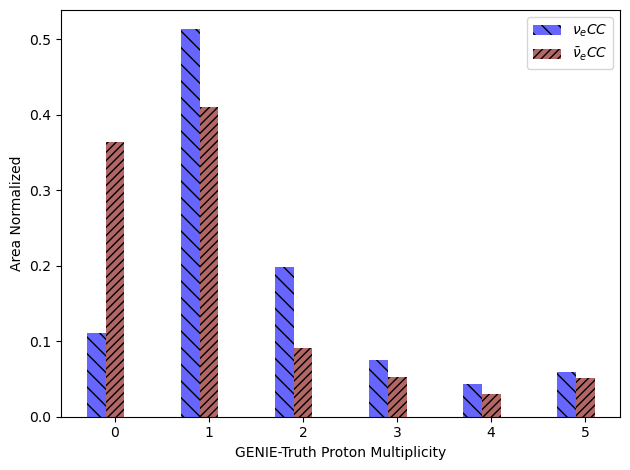

In [65]:
plot_discrete_multiplicity(df_nuecc, df_nuebar,
                           column="GenieEvtRec_Num_Proton",
                           xlabel="GENIE-Truth Proton Multiplicity",
                           max_val=6)

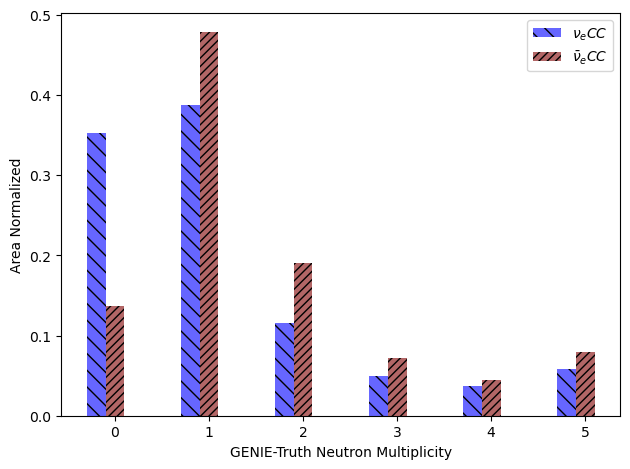

In [66]:
plot_discrete_multiplicity(df_nuecc, df_nuebar,
                           column="GenieEvtRec_Num_Neutron",
                           xlabel="GENIE-Truth Neutron Multiplicity",
                           max_val=6)

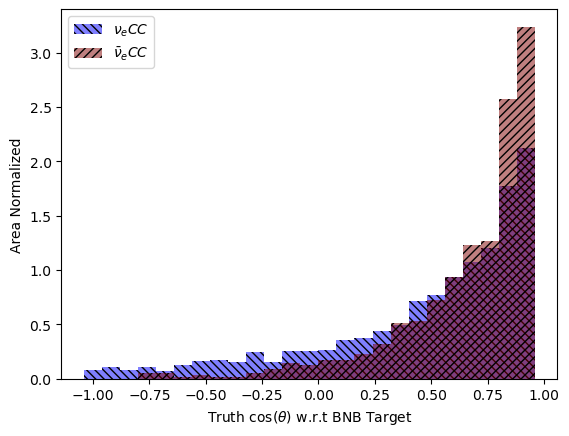

In [67]:
plt.hist(df_nuecc['cos_theta_bnb_target'], 25, (-1,1), density=True, label=r'$\nu_{e}CC$', align='left', alpha=.5, color='blue',hatch='\\\\\\\\')
plt.hist(df_nuebar['cos_theta_bnb_target'], 25, (-1,1), density=True, label= r'$\bar{\nu}_{e}CC$', align='left', alpha=.5, color='maroon',hatch='////')
plt.xlabel(r"Truth cos($\theta$) w.r.t BNB Target")
plt.ylabel("Area Normalized")
plt.legend()
plt.show()

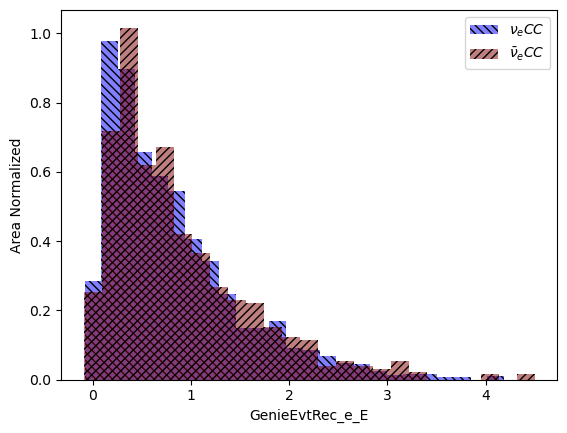

In [68]:
plt.hist(df_nuecc["GenieEvtRec_e_E"], 25, density=True, label=r'$\nu_{e}CC$', align='left', alpha=.5, color='blue',hatch='\\\\\\\\')
plt.hist(df_nuebar["GenieEvtRec_e_E"], 25, density=True, label= r'$\bar{\nu}_{e}CC$', align='left', alpha=.5, color='maroon',hatch='////')
plt.xlabel("GenieEvtRec_e_E")
plt.ylabel("Area Normalized")
plt.legend()
plt.show()

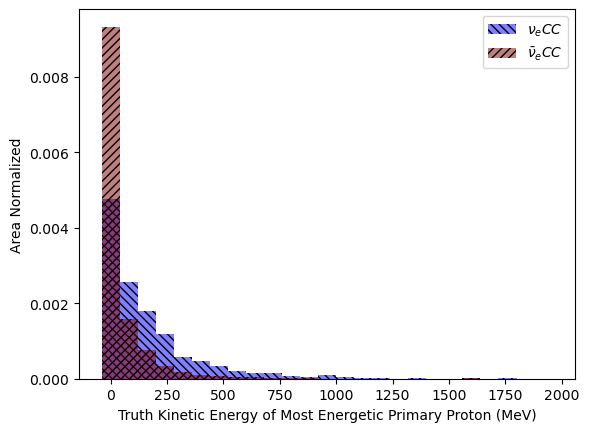

In [69]:
plt.hist(df_nuecc['GenieEvtRec_Proton_Tmax'], 25, (0.,2000.), density=True, label=r'$\nu_{e}CC$', align='left', alpha=.5, color='blue',hatch='\\\\\\\\')
plt.hist(df_nuebar['GenieEvtRec_Proton_Tmax'], 25, (0.,2000.), density=True, label= r'$\bar{\nu}_{e}CC$', align='left', alpha=.5, color='maroon',hatch='////')
plt.xlabel("Truth Kinetic Energy of Most Energetic Primary Proton (MeV)")
plt.ylabel("Area Normalized")
plt.legend()
plt.show()

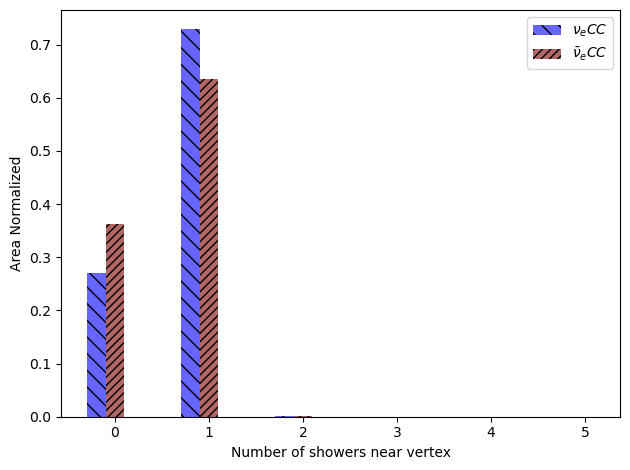

In [70]:
plot_discrete_multiplicity(df_nuecc, df_nuebar,
                           column="n_showers",
                           xlabel="Number of showers near vertex",
                           max_val=6)